# **MNIST centralized**

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import torch.nn.functional as F 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader

## Define any transforms you need; at minimum, convert to Tensor

In [2]:
transform = transforms.ToTensor()

# This will download MNIST into ./data if it’s not already there

In [3]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

In [4]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [5]:
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 60000
Test set size: 10000


## Load MNIST and preprocess

In [6]:
transform = transforms.ToTensor()
train_ds_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
X_full = train_ds_full.data.numpy().reshape(-1, 28*28).astype(np.float32) / 255.0
y_full = train_ds_full.targets.numpy().astype(np.int64)
X_test = test_ds.data.numpy().reshape(-1, 28*28).astype(np.float32) / 255.0
y_test = test_ds.targets.numpy().astype(np.int64)

## Train/val split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

## To Tensors & DataLoaders

In [8]:
def to_loader(X, y, batch_size=64, shuffle=False):
    tX = torch.from_numpy(X)
    ty = torch.from_numpy(y)
    ds = TensorDataset(tX, ty)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(X_train, y_train, shuffle=True)
val_loader   = to_loader(X_val,   y_val)
test_loader  = to_loader(X_test,  y_test)

## Model (same as yours, final layer → 10)

In [9]:
class MNISTMLP(nn.Module):
    def __init__(self, mlp_hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, mlp_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(mlp_hidden, mlp_hidden//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(mlp_hidden//2, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

## Loss & optimizer

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

## Training / evaluation loops

In [11]:
def train_epoch(loader):
    model.train()
    total_loss, correct = 0.0, 0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
    return total_loss/len(loader.dataset), correct/len(loader.dataset)

In [12]:
def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * Xb.size(0)
            correct += (out.argmax(dim=1) == yb).sum().item()
    return total_loss/len(loader.dataset), correct/len(loader.dataset)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

best_val, wait, patience = float('inf'), 0, 5
for epoch in range(1, 21):
    tr_loss, tr_acc = train_epoch(train_loader)
    va_loss, va_acc = eval_epoch(val_loader)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    print(f"Epoch {epoch} | Train loss {tr_loss:.4f}, acc {tr_acc:.3f} | Val loss {va_loss:.4f}, acc {va_acc:.3f}")
    if va_loss < best_val:
        best_val, wait = va_loss, 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

Epoch 1 | Train loss 0.9966, acc 0.724 | Val loss 0.4102, acc 0.893
Epoch 2 | Train loss 0.4326, acc 0.874 | Val loss 0.3103, acc 0.913
Epoch 3 | Train loss 0.3515, acc 0.898 | Val loss 0.2620, acc 0.924
Epoch 4 | Train loss 0.3003, acc 0.913 | Val loss 0.2315, acc 0.933
Epoch 5 | Train loss 0.2679, acc 0.922 | Val loss 0.2068, acc 0.940
Epoch 6 | Train loss 0.2401, acc 0.930 | Val loss 0.1890, acc 0.944
Epoch 7 | Train loss 0.2160, acc 0.937 | Val loss 0.1729, acc 0.948
Epoch 8 | Train loss 0.2006, acc 0.941 | Val loss 0.1587, acc 0.952
Epoch 9 | Train loss 0.1829, acc 0.946 | Val loss 0.1474, acc 0.956
Epoch 10 | Train loss 0.1688, acc 0.950 | Val loss 0.1400, acc 0.956
Epoch 11 | Train loss 0.1615, acc 0.953 | Val loss 0.1322, acc 0.959
Epoch 12 | Train loss 0.1502, acc 0.955 | Val loss 0.1247, acc 0.963
Epoch 13 | Train loss 0.1395, acc 0.958 | Val loss 0.1179, acc 0.964
Epoch 14 | Train loss 0.1308, acc 0.961 | Val loss 0.1131, acc 0.966
Epoch 15 | Train loss 0.1247, acc 0.963 | V

## Plot loss & accuracy

<Figure size 1000x500 with 0 Axes>

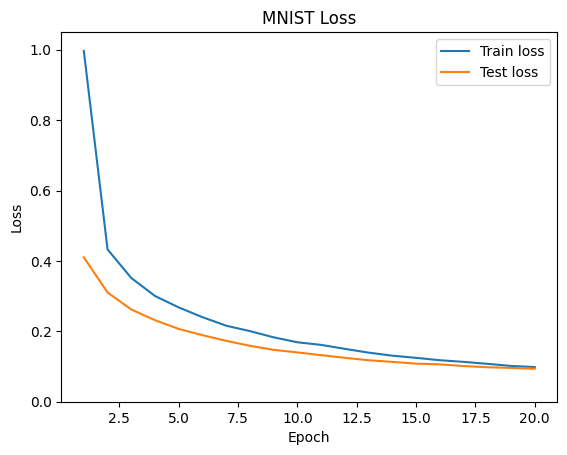

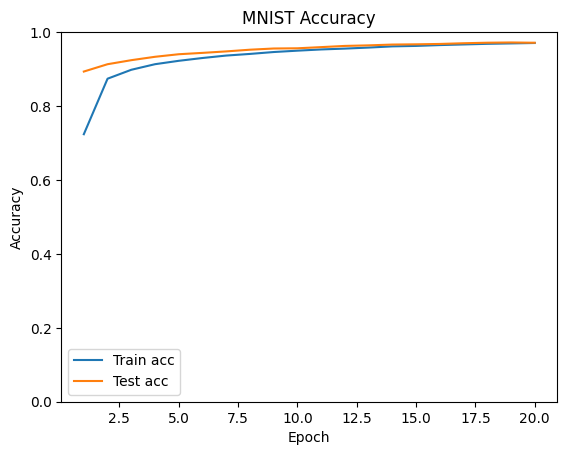

In [25]:
epochs = range(1, len(history["train_loss"])+1)
plt.figure(figsize=(10, 5))
plt.figure(); plt.plot(epochs, history["train_loss"], label='Train loss'); plt.plot(epochs, history["val_loss"], label='Test loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('MNIST Loss'); plt.legend(); plt.ylim(0,1.05); plt.show()
plt.figure(); plt.plot(epochs, history["train_acc"], label='Train acc'); plt.plot(epochs, history["val_acc"], label='Test acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('MNIST Accuracy'); plt.legend(); plt.ylim(0,1); plt.show()

## Test set metrics

In [ ]:
def evaluate_classification_centralized(model, loader, device):
    model.eval().to(device)
    all_probs_list = [] # Use a list to append batches of probabilities
    all_labels_list = [] # Use a list to append batches of labels

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)
            # It's generally better to use torch.softmax
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs_list.append(probs)
            all_labels_list.append(yb.cpu().numpy()) # Ensure labels are also moved to CPU before converting to numpy

    all_probs  = np.concatenate(all_probs_list, axis=0)
    all_labels = np.concatenate(all_labels_list, axis=0)

    # Predicted classes
    preds = all_probs.argmax(axis=1)

    # Precision / Recall / F1
    print("Classification report:\n")
    print(classification_report(all_labels, preds, digits=4))

    # Confusion matrix
    print("Confusion matrix:\n")
    print(confusion_matrix(all_labels, preds))

    roc_auc = roc_auc_score(all_labels, all_probs,
                            multi_class='ovr', average='macro')

    pr_auc  = average_precision_score(all_labels, all_probs,
                                      average='macro')

    print(f"ROC-AUC (macro OvR):       {roc_auc:.4f}")
    print(f"PR-AUC (avg precision):    {pr_auc:.4f}")
    print()

print("=== Centralized Model Metrics ===")
evaluate_classification_centralized(model, test_loader, device)

=== Centralized Model Metrics ===
Classification report:

              precision    recall  f1-score   support

           0     0.9729    0.9898    0.9813       980
           1     0.9833    0.9859    0.9846      1135
           2     0.9730    0.9767    0.9749      1032
           3     0.9666    0.9733    0.9699      1010
           4     0.9765    0.9735    0.9750       982
           5     0.9677    0.9731    0.9704       892
           6     0.9680    0.9781    0.9730       958
           7     0.9792    0.9621    0.9706      1028
           8     0.9709    0.9579    0.9643       974
           9     0.9689    0.9574    0.9631      1009

    accuracy                         0.9729     10000
   macro avg     0.9727    0.9728    0.9727     10000
weighted avg     0.9729    0.9729    0.9729     10000

Confusion matrix:

[[ 970    0    1    1    0    3    2    1    1    1]
 [   0 1119    3    2    0    1    4    1    5    0]
 [   6    1 1008    3    1    0    2    3    8    0]
 [   

## t-SNE visualization of penultimate-layer features

### build a feature‐extractor (everything up to, but not including, the final Linear)

In [15]:
feat_extractor = nn.Sequential(*list(model.net.children())[:-1]).to(device)
model.eval()

MNISTMLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

### gather features + labels on the test set

In [ ]:
all_feats, all_labels = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        feats = feat_extractor(Xb) 
        all_feats.append(feats.cpu().numpy())
        all_labels.append(yb.numpy())
all_feats = np.concatenate(all_feats, axis=0)
all_labels = np.concatenate(all_labels, axis=0)